In [17]:
library(nichenetr)
library(Seurat)
library(ComplexHeatmap)
library(circlize)
library(cowplot)
library(ggpubr)
library(tidyverse)
library(patchwork)

source('utils/nichenet_utils.R')

In [3]:
inf.seu <- readRDS('outputs/inf_neu_tany_micro_seuobj.rds')

In [7]:
inf.seu$subtype4nn <- fct_collapse(inf.seu$subtype4cc
                                   , 'Neuron' = c('i23:AGRP/MCTP2', 'i26:GALP/HTR2C'
                                                  , 'i33:KISS1/ESR1', 'i40:GHRH/PIK3R1'
                                                  , 'i9:POMC/TBX3')
                                   , 'Tanycyte' = c('tany_a', 'tany_b')
                                   , 'Microglia' = c('micro-1', 'micro-2'))

In [9]:
inf.ob.seu <- subset(inf.seu, diabetes %in% c('Control', 'Obesity'))
inf.db.seu <- subset(inf.seu, diabetes %in% c('Control', 'Diabetes'))

In [11]:
table(inf.ob.seu$diabetes, inf.ob.seu$subtype4nn)
table(inf.db.seu$diabetes, inf.db.seu$subtype4nn)

         
          Neuron Microglia Tanycyte
  Control  16054      3055     6880
  Obesity   9663      3881     9356

          
           Neuron Microglia Tanycyte
  Control   16054      3055     6880
  Diabetes   3090      3350     3196

In [8]:
# 加载先验模型
# Read in NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks: 
ligand_target_matrix = readRDS("ref/ligand_target_matrix.rds")
ligand_target_matrix[1:5,1:5] # target genes in rows, ligands in columns

lr_network = readRDS("ref/lr_network.rds")
head(lr_network)

weighted_networks = readRDS("ref/weighted_networks.rds")
weighted_networks_lr = weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to"))

head(weighted_networks$lr_sig) # interactions and their weights in the ligand-receptor + signaling network

head(weighted_networks$gr) # interactions and their weights in the gene regulatory network

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg
CXCL3,CXCR2,kegg_cytokines,kegg
CXCL5,CXCR2,kegg_cytokines,kegg
PPBP,CXCR2,kegg_cytokines,kegg
CXCL6,CXCR2,kegg_cytokines,kegg


from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.42164389
A1BG,ACE2,0.10074109
A1BG,ADAM10,0.09698978
A1BG,AGO1,0.05245879
A1BG,AKT1,0.08553468
A1BG,ANXA7,0.45659947


from,to,weight
<chr>,<chr>,<dbl>
A1BG,A2M,0.02944793
AAAS,GFAP,0.02904173
AADAC,CYP3A4,0.04215706
AADAC,IRF8,0.02745930
AATF,ATM,0.03299318
AATF,ATR,0.03545127


In [38]:
# load selected genes

immue_goi <- read.csv("select_pathway_gene/immune_gene.csv"
                      , row.names = 1) %>%
                pull(x) %>% unique()
assembly_goi <- read.csv("select_pathway_gene/assembly_gene.csv"
                         , row.names = 1) %>%
                pull(x) %>% unique()

plasticity_goi <- read.csv("select_pathway_gene/neuron_plasticity_gene.csv"
                           , row.names = 1) %>%
                pull(x) %>% unique()

target.gene <- unique(c(immue_goi, assembly_goi, plasticity_goi))
target.gene <- target.gene %>% .[. %in% rownames(ligand_target_matrix)]

In [22]:
target.gene

[1] "TSPAN6"   "ITFG2"    "IFI6"     "EXOC1"    "DHX58"    "BTN3A2"  
  [7] "HLA-E"    "DDX3X"    "MX1"      "SPNS2"    "TRIM25"   "TNK2"    
 [13] "DDX17"    "MOV10"    "RBCK1"    "LRSAM1"   "RAP1GAP"  "PKN1"    
 [19] "PLCG1"    "FLNB"     "ARRB2"    "IRF9"     "NLRC5"    "STAT1"   
 [25] "TAP1"     "STAT2"    "AIRE"     "ADAR"     "DDX60"    "ILF3"    
 [31] "BTN3A1"   "PML"      "MST1R"    "SIRPA"    "AKAP8"    "WNK1"    
 [37] "AKAP1"    "PARP9"    "DAPK3"    "CACNB3"   "CDC37"    "DGKZ"    
 [43] "DDX58"    "IFIT1"    "SCAP"     "SHC1"     "STAT5B"   "ALCAM"   
 [49] "NUB1"     "NFKBIA"   "CALCOCO2" "MAPKBP1"  "NOP53"    "IFI27"   
 [55] "PARP14"   "ABCF3"    "STAT3"    "TUBB4B"   "SLC26A6"  "CD276"   
 [61] "COLEC12"  "WRNIP1"   "STAB1"    "OAS3"     "ATG16L1"  "NONO"    
 [67] "DDIT4"    "TRIM27"   "IKBKG"    "TCIRG1"   "PQBP1"    "PTPRS"   
 [73] "MTOR"     "SERPING1" "METTL3"   "MAP2K7"   "EIF2B4"   "SEMA4D"  
 [79] "MAPK8"    "DAB2IP"   "EIF2B5"   "IRAK2"    "APPL2"    "SFPQ"    
 [85] "TNIP2"    "ADGRB1"   "BTNL8"    "IFNGR1"   "EIF2B1"   "ZYX"     
 [91] "LTBR"     "OTUB1"    "CHUK"     "DHX36"    "KDM6B"    "SIRT2"   
 [97] "PAK1"     "PDPK1"    "SARM1"    "ADAMTS13" "LRP8"     "POLR3A"  
[103] "LRP1"     "PHPT1"    "TYK2"     "POU2F2"   "IKBKB"    "STXBP1"  
[109] "OTUD4"    "PCBP2"    "IFI35"    "GPLD1"    "TRIM39"   "CHID1"   
[115] "FLOT1"    "CCL27"    "IFIT3"    "SP100"    "CYBA"     "NLRX1"   
[121] "RELA"     "CTSK"     "MAP3K14"  "ERCC1"    "MAPK9"    "TSC1"    
[127] "TP53BP1"  "MAPKAPK2" "PIK3CD"   "PSMB4"    "PLK2"     "EIF2AK2" 
[133] "BTN2A1"   "MAPK3"    "LAT"      "TRAFD1"   "NSD2"     "IL18BP"  
[139] "STK11"    "BST1"     "B2M"      "MX2"      "IFI44"    "SUSD4"   
[145] "THY1"     "CRCP"     "SUPT6H"   "VAV2"     "TFE3"     "SEMA4A"  
[151] "ZAP70"    "HRAS"     "EP300"    "IFIT2"    "BAG6"     "FER1L5"  
[157] "ADAM8"    "SLC15A2"  "SH2B2"    "POLR3B"   "GTPBP1"   "FAM3A"   
[163] "POLR3E"   "PAXIP1"   "CREBBP"   "GBF1"     "UFD1"     "TRIM26"  
[169] "ADAM15"   "HK1"      "MAP3K5"   "CNPY3"    "PLEKHA1"  "SPON2"   
[175] "BCL6"     "PRKD2"    "SLC15A4"  "SMPD1"    "OPTN"     "DYSF"    
[181] "LOXL3"    "ADCY7"    "TP53"     "TBK1"     "ENPP2"    "SRC"     
[187] "SEMA3C"   "DDX1"     "DAPK1"    "IL34"     "AGBL5"    "FYN"     
[193] "HMCES"    "PIANP"    "CD47"     "FBXO9"    "EXOSC9"   "PLD2"    
[199] "TMF1"     "PTPN2"    "PRKCZ"    "CD200"    "ELMOD2"   "POLR3C"  
[205] "PCLO"     "GPC6"     "CDH2"     "ASIC2"    "PTEN"     "CNTN5"   
[211] "ADGRL3"   "DSCAM"    "GAP43"    "LRRTM3"   "NTRK2"    "KIRREL3" 
[217] "PPP1R9A"  "ROBO2"    "GPM6A"    "MAP1B"    "IL1RAPL1" "SDK1"    
[223] "DNM3"     "LRFN5"    "ADGRB3"   "APP"      "ERBB4"    "NRXN1"   
[229] "NLGN1"    "GRID2"    "NRG1"     "FGF13"    "PTPRD"    "PDLIM5"  
[235] "PCDH17"   "EFNB2"    "GABRA2"   "UBE2V2"   "DNER"     "GABRB2"  
[241] "IL1RAPL2" "GABRG2"   "GABRA1"   "CBLN4"    "CLSTN2"   "LRRC4B"  
[247] "SDCBP"    "LRRC4"    "LRRC24"   "GNPAT"    "EPHB1"    "AGRN"    
[253] "SLIT1"    "SHANK2"   "LRTM2"    "SPOCK2"   "OXT"      "ADGRL2"  
[259] "NTRK3"    "FARP1"    "LRRTM2"   "GABRB3"   "CLSTN1"   "CLSTN3"  
[265] "ADD2"     "NPTN"     "OBSL1"    "RYK"      "NRCAM"    "ADNP"    
[271] "MEF2C"    "MCTP1"    "VAMP2"    "RAB5A"    "SLC24A2"  "YWHAH"   
[277] "NCDN"     "GRIN2B"   "SHISA9"   "ARF1"     "LGMN"     "GFAP"    
[283] "RAB11A"   "CREB1"    "RASGRF2"  "ZDHHC2"   "SORCS3"   "RAPGEF2" 
[289] "ERC2"     "GSK3B"    "CNTN4"    "RIMS1"    "GRIK2"    "APOE"    
[295] "GRM5"     "ERC1"     "CPEB3"    "RIMS2"    "FGF14"    "SLC8A3"  
[301] "NSG1"     "CALB1"    "NETO1"    "RELN"     "MAP1A"    "S100B"   
[307] "UNC13C"   "SLC4A10"  "CAMK2A"   "SYNGR1"   "SNAP25"   "PRRT1"   
[313] "TNR"      "RAB3A"    "SQSTM1"   "SCGN"     "MAPK1"    "GRIA1"   
[319] "EPHA4"    "YWHAG"

# Diabetes

In [23]:
inf.db.seu$subtype <- inf.db.seu$subtype4nn
Idents(inf.db.seu) <- 'subtype'

inf.db.nn.res <- preform_nn_analysis(inf.db.seu
                                     , target.gene = target.gene
                                     , receiver = 'Neuron'
                                     , sender = c('Tanycyte', 'Microglia')
                                     , group.by = "diabetes"
                                     , ident.1 = "Control"
                                     , ident.2 = "Diabetes"
                                     # , logfc.threshold = log2(1.5)
                                     # , test.use = "MAST"
                                     , ligand_target_matrix = ligand_target_matrix
                                     , lr_network = lr_network
                                     , weighted_networks = weighted_networks)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


$ligand_activities
# A tibble: 91 × 6
   test_ligand auroc   aupr aupr_corrected pearson  rank
   <chr>       <dbl>  <dbl>          <dbl>   <dbl> <dbl>
 1 RTN4        0.617 0.0558         0.0405  0.113      1
 2 IL18        0.705 0.0488         0.0335  0.104      2
 3 PTPRC       0.692 0.0475         0.0322  0.0944     3
 4 PIK3CB      0.679 0.0404         0.0251  0.0846     4
 5 EFNA5       0.666 0.0462         0.0309  0.0806     5
 6 FGF1        0.657 0.0363         0.0210  0.0798     6
 7 VEGFB       0.665 0.0474         0.0321  0.0793     7
 8 PROS1       0.661 0.0363         0.0210  0.0770     8
 9 CSF1        0.659 0.0349         0.0196  0.0756     9
10 NRG3        0.666 0.0344         0.0191  0.0753    10
# … with 81 more rows

$top_ligands
 [1] "RTN4"     "IL18"     "PTPRC"    "PIK3CB"   "EFNA5"    "FGF1"    
 [7] "VEGFB"    "PROS1"    "CSF1"     "NRG3"     "TNFSF13"  "SERPING1"
[13] "ITGAM"    "C3"       "NCAM1"    "SEMA3B"   "TIMP1"    "TNC"     
[19] "HLA-E"    "GMFB"    

$

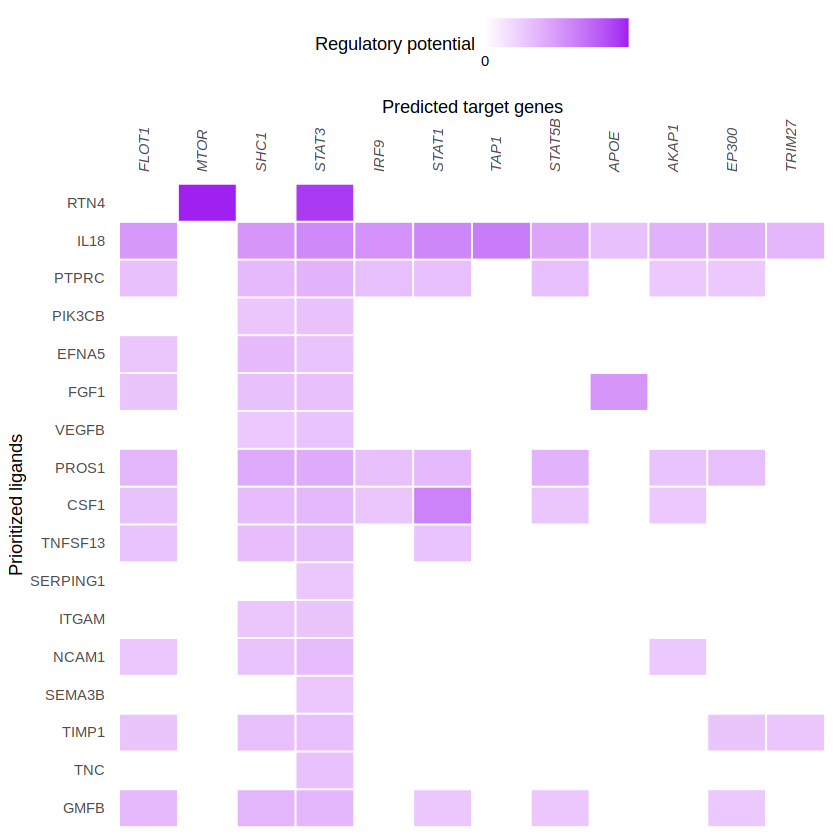

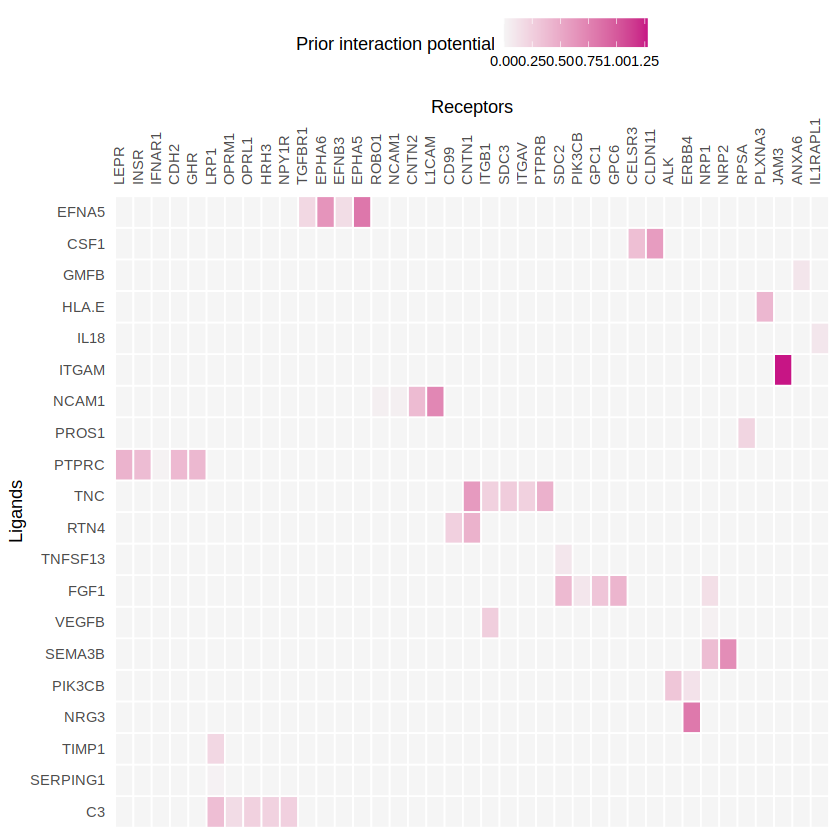

In [27]:
inf.db.nn.res

In [57]:
avg_expression_ligands = AverageExpression(inf.db.seu %>% subset(subtype %in% c("Tanycyte", "Microglia"))
                                           , features = inf.db.nn.res$top_ligands)

Warning message:
“The following 10 features were not found in the integrated assay: PIK3CB, VEGFB, PROS1, CSF1, TNFSF13, SERPING1, C3, TIMP1, TNC, GMFB”


In [58]:
avg_expression_ligands

,Microglia,Tanycyte
RTN4,4.9943055,6.19247977
IL18,7.5225269,0.38902456
PTPRC,5.5005588,0.09919900
PIK3CB,1.9870950,1.12999867
EFNA5,0.6538725,5.43352763
FGF1,0.1455868,0.86980150
VEGFB,0.9323946,0.90341058
PROS1,1.0342729,1.77104147
CSF1,0.1047337,0.82149340
NRG3,1.7830749,2.28339984


In [88]:
sender_ligand_assignment <- avg_expression_ligands$RNA
for(ligand_row in 1:nrow(sender_ligand_assignment)){
    if (sender_ligand_assignment[ligand_row, 1] - sender_ligand_assignment[ligand_row, 2] < -0.5)
        sender_ligand_assignment[ligand_row,] <- c(FALSE, TRUE) 
    else if(sender_ligand_assignment[ligand_row, 1] - sender_ligand_assignment[ligand_row, 2] > 0.5)
        sender_ligand_assignment[ligand_row, ] <- c(TRUE, FALSE)
    else
        sender_ligand_assignment[ligand_row, ] <- c(TRUE, TRUE)
}
sender_ligand_assignment <- as.data.frame(sender_ligand_assignment)

In [89]:
general_ligands <- filter(sender_ligand_assignment, Microglia == 1 & Tanycyte == 1) %>% rownames()
tany_unique_ligands <- filter(sender_ligand_assignment, Microglia == 0 & Tanycyte == 1) %>% rownames()
micro_unique_ligands <- filter(sender_ligand_assignment, Microglia == 1 & Tanycyte == 0) %>% rownames()

In [90]:
general_ligands
tany_unique_ligands
micro_unique_ligands

[1] "VEGFB" "GMFB"

[1] "RTN4"     "EFNA5"    "FGF1"     "PROS1"    "CSF1"     "NRG3"    
 [7] "SERPING1" "NCAM1"    "SEMA3B"   "TIMP1"    "TNC"

[1] "IL18"    "PTPRC"   "PIK3CB"  "TNFSF13" "ITGAM"   "C3"      "HLA-E"

In [91]:
ligand_type_indication_df = tibble(
  ligand_type = c(rep("General", times = general_ligands %>% length()),
                  rep("tanycyte_high", times = tany_unique_ligands %>% length()),
                  rep("microglia_high", times = micro_unique_ligands %>% length())),
  ligand = c(general_ligands, tany_unique_ligands, micro_unique_ligands))

In [102]:
# circos_links = active_ligand_target_links_df %>% filter(!target %in% targets_to_remove &!ligand %in% ligands_to_remove)
active_ligand_target_links_df = inf.db.nn.res$active_ligand_target_links_df %>% 
    mutate(target_type = "Neuron") %>% 
    inner_join(ligand_type_indication_df)
cutoff_include_all_ligands = active_ligand_target_links_df$weight %>% quantile(0.33)

active_ligand_target_links_df_circos = active_ligand_target_links_df %>% 
    filter(weight > cutoff_include_all_ligands)

ligands_to_remove = setdiff(active_ligand_target_links_df$ligand %>% 
                                unique()
                            , active_ligand_target_links_df_circos$ligand %>% 
                                unique())
targets_to_remove = setdiff(active_ligand_target_links_df$target %>% 
                                unique()
                            , active_ligand_target_links_df_circos$target %>% 
                                unique())
  
circos_links = active_ligand_target_links_df %>% 
    filter(!target %in% targets_to_remove &!ligand %in% ligands_to_remove)

Joining, by = "ligand"


In [103]:
immue_gene <- circos_links$target[circos_links$target %in% immue_goi] %>% unique()
immue_gene
assembly_gene <- circos_links$target[circos_links$target %in% assembly_goi] %>% unique()
assembly_gene
plasticity_gene <- circos_links$target[circos_links$target %in% plasticity_goi] %>% unique()
plasticity_gene

[1] "FLOT1"  "MTOR"   "SHC1"   "STAT3"  "IRF9"   "STAT1"  "TAP1"   "STAT5B"
 [9] "EP300"  "TRIM27"

character(0)

[1] "APOE"

In [104]:
grid_col_ligand =c("General" = "#0075c2",
            "tanycyte_high" = "#37a34a",
            "microglia_high" = "#fcc800")
grid_col_target =c(
            "Neuron" = "#ea553a")

grid_col_tbl_ligand = tibble(ligand_type = grid_col_ligand %>% names(), color_ligand_type = grid_col_ligand)
grid_col_tbl_target = tibble(target_type = grid_col_target %>% names(), color_target_type = grid_col_target)

circos_links = circos_links %>% 
    mutate(ligand = paste(ligand," ")) # extra space: make a difference between a gene as ligand and a gene as target!
circos_links = circos_links %>% 
    inner_join(grid_col_tbl_ligand) %>% inner_join(grid_col_tbl_target)
links_circle = circos_links %>% 
    select(ligand,target, weight)

ligand_color = circos_links %>% 
    distinct(ligand,color_ligand_type)
grid_ligand_color = ligand_color$color_ligand_type %>% 
    set_names(ligand_color$ligand)
target_color = circos_links %>% 
    distinct(target,color_target_type)
grid_target_color = target_color$color_target_type %>% 
    set_names(target_color$target)

grid_col =c(grid_ligand_color,grid_target_color)

# give the option that links in the circos plot will be transparant ~ ligand-target potential score
transparency = circos_links %>% 
    mutate(weight = (weight-min(weight))/(max(weight)-min(weight))) %>% 
    mutate(transparency = 1-weight) %>% .$transparency 

Joining, by = "ligand_type"
Joining, by = "target_type"


In [105]:
target_order = c(immue_gene, assembly_gene, plasticity_gene) %>% unique
ligand_order = c(general_ligands, tany_unique_ligands, micro_unique_ligands) %>% c(paste(.," ")) %>% intersect(circos_links$ligand)
order = c(ligand_order,target_order)

In [106]:
unique(circos_links)

ligand,target,weight,target_type,ligand_type,color_ligand_type,color_target_type
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
RTN4,FLOT1,0.0007997330,Neuron,tanycyte_high,#37a34a,#ea553a
RTN4,MTOR,0.0039572920,Neuron,tanycyte_high,#37a34a,#ea553a
RTN4,SHC1,0.0009430522,Neuron,tanycyte_high,#37a34a,#ea553a
RTN4,STAT3,0.0036541092,Neuron,tanycyte_high,#37a34a,#ea553a
IL18,FLOT1,0.0020371225,Neuron,microglia_high,#fcc800,#ea553a
IL18,IRF9,0.0021583606,Neuron,microglia_high,#fcc800,#ea553a
IL18,SHC1,0.0020794478,Neuron,microglia_high,#fcc800,#ea553a
IL18,STAT1,0.0023587445,Neuron,microglia_high,#fcc800,#ea553a
IL18,STAT3,0.0023170136,Neuron,microglia_high,#fcc800,#ea553a


In [107]:
width_same_cell_same_ligand_type = 0.5
width_different_cell = 6
width_ligand_target = 15
width_same_cell_same_target_type = 0.5

gaps = c(
  # width_ligand_target,
  rep(width_same_cell_same_ligand_type, times = (circos_links %>% filter(ligand_type == "General") %>% distinct(ligand) %>% nrow() -1)),
  width_different_cell,
  rep(width_same_cell_same_ligand_type, times = (circos_links %>% filter(ligand_type == "tanycyte_high") %>% distinct(ligand) %>% nrow() -1)),
  width_different_cell,
  rep(width_same_cell_same_ligand_type, times = (circos_links %>% filter(ligand_type == "microglia_high") %>% distinct(ligand) %>% nrow() -1)),
  width_different_cell,
  rep(width_same_cell_same_target_type, times = (circos_links %>% filter(target_type == "Neuron") %>% distinct(target) %>% nrow() -1)),
  width_ligand_target
  )

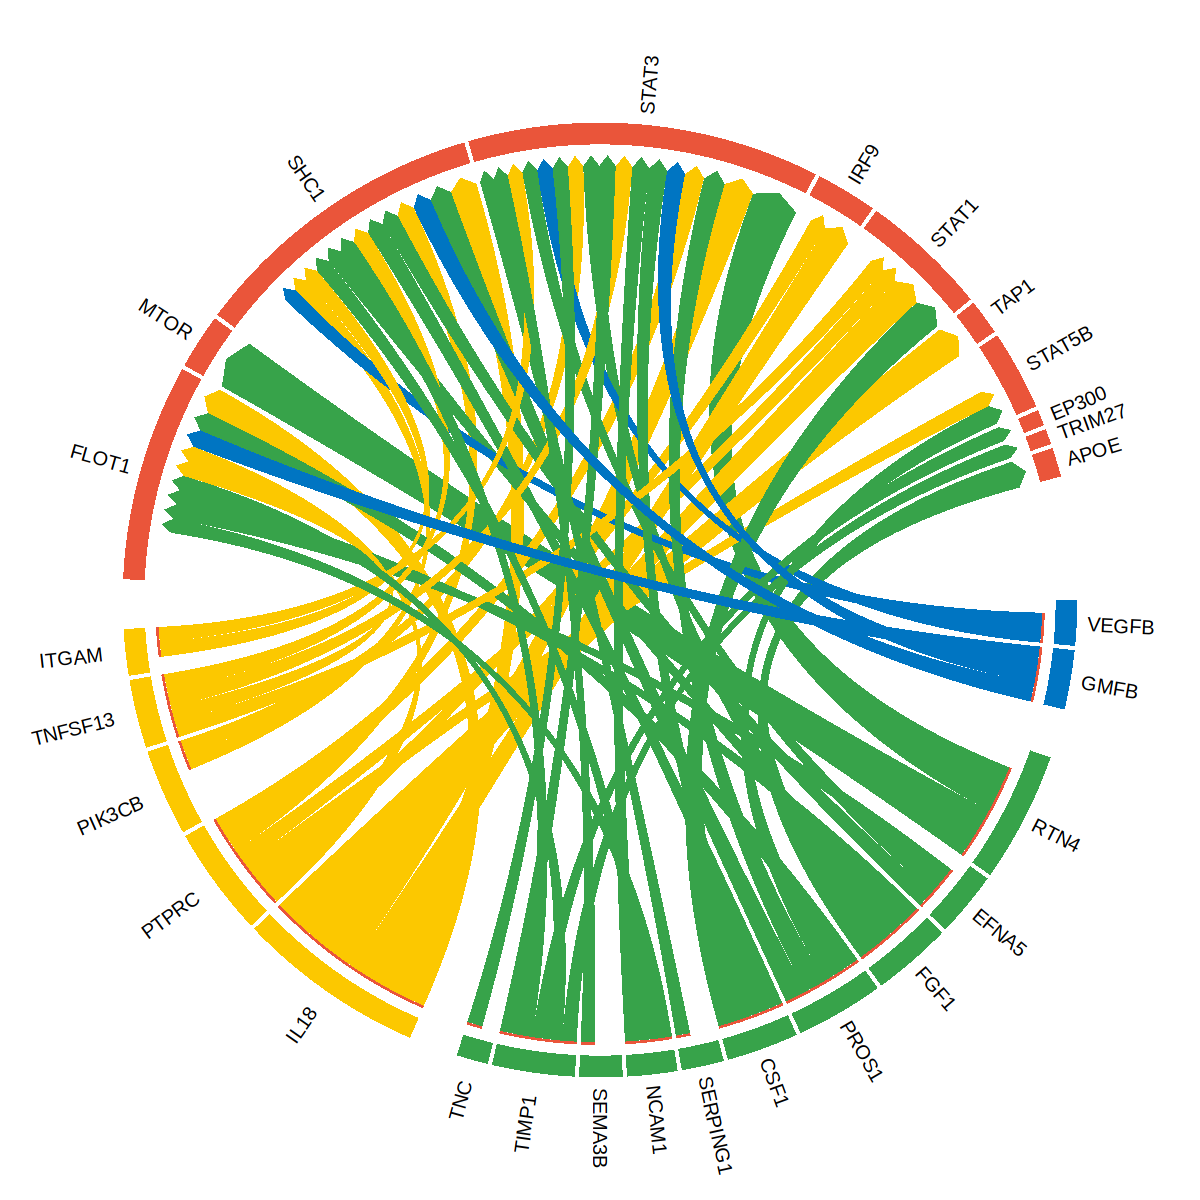

In [108]:
circos.clear()
options(repr.plot.width = 10, repr.plot.height = 10)
circos.par(gap.degree = gaps)
chordDiagram(links_circle, directional = 1,order=order,link.sort = TRUE, link.decreasing = FALSE, grid.col = grid_col,transparency = 0, diffHeight = 0.005, direction.type = c("diffHeight", "arrows"),link.arr.type = "big.arrow", link.visible = links_circle$weight >= cutoff_include_all_ligands,annotationTrack = "grid", 
    preAllocateTracks = list(track.height = 0.075))
# we go back to the first track and customize sector labels
circos.track(track.index = 1, panel.fun = function(x, y) {
    circos.text(CELL_META$xcenter, CELL_META$ylim[1], CELL_META$sector.index,
        facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.55), cex = 1)
}, bg.border = NA) #

In [109]:
pdf('outputs/db_nichenet.pdf', width = 5, height = 5)
circos.clear()
options(repr.plot.width = 10, repr.plot.height = 10)
circos.par(gap.degree = gaps)
chordDiagram(links_circle, directional = 1,order=order,link.sort = TRUE, link.decreasing = FALSE, grid.col = grid_col,transparency = 0, diffHeight = 0.005, direction.type = c("diffHeight", "arrows"),link.arr.type = "big.arrow", link.visible = links_circle$weight >= cutoff_include_all_ligands,annotationTrack = "grid", 
    preAllocateTracks = list(track.height = 0.075))
# we go back to the first track and customize sector labels
circos.track(track.index = 1, panel.fun = function(x, y) {
    circos.text(CELL_META$xcenter, CELL_META$ylim[1], CELL_META$sector.index,
        facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.55), cex = 1)
}, bg.border = NA) #
dev.off()

png 
  2

In [112]:
pdf('outputs/inf_db_lr_network.pdf', width = 6, height = 5)
inf.db.nn.res$p_ligand_receptor_network
dev.off()

png 
  2

In [114]:
saveRDS(inf.db.nn.res, 'outputs/INF_DB_NN.rds')

# Obesity

In [115]:
inf.ob.seu$subtype <- inf.ob.seu$subtype4nn
Idents(inf.ob.seu) <- 'subtype'

inf.ob.nn.res <- preform_nn_analysis(inf.ob.seu
                                     , target.gene = target.gene
                                     , receiver = 'Neuron'
                                     , sender = c('Tanycyte', 'Microglia')
                                     , group.by = "diabetes"
                                     , ident.1 = "Control"
                                     , ident.2 = "Obesity"
                                     # , logfc.threshold = log2(1.5)
                                     # , test.use = "MAST"
                                     , ligand_target_matrix = ligand_target_matrix
                                     , lr_network = lr_network
                                     , weighted_networks = weighted_networks)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
